The data generator creates a dataset with **n** categories, each containing **m** values.

In [2]:
import pandas as pd
import numpy as np

def generate_dataset(n, m, value_type='binary'):

    # Generate the categorical values
    categories = [f"Category_{i+1}" for i in range(n)]
    categorical_column = np.repeat(categories, m)

    # Generate the 'Value' column based on type
    if value_type == 'continuous':
        value_column = np.random.rand(n * m)
    else:
        # default to binary
        value_column = np.random.randint(0, 2, size=n * m)

    # Create and return the DataFrame
    return pd.DataFrame({
        'Category': categorical_column,
        'Value': value_column
    })


Either consider all possible splits of the categories into two non-empty groups, or only those that follow the order defined by mean target encoding.

In [3]:
from itertools import combinations

def all_category_splits(df):
    # 1) Sort so tuple-comparison is stable
    cats = tuple(sorted(df['Category'].unique()))
    n = len(cats)
    half = n // 2

    for i in range(1, half + 1):
        for combo in combinations(cats, i):
            # 2) If it's exactly half of an even n, only yield one side:
            if i == half and n % 2 == 0:
                complement = tuple(c for c in cats if c not in combo)
                # lex-skip the “larger” half of each mirror pair
                if combo > complement:
                    continue

            mask = df['Category'].isin(combo)
            yield df[mask], df[~mask]

def mean_target_encode(df):
    mean_map = df.groupby('Category')['Value'].mean().to_dict()
    encoded_column = df['Category'].map(mean_map)
    return encoded_column, mean_map

def ordered_splits(df):
    # Perform mean target encoding
    encoded_column, mean_map = mean_target_encode(df)
    df_encoded = df.copy()
    df_encoded['Encoded'] = encoded_column

    # Sort by encoded values
    df_sorted = df_encoded.sort_values(by='Encoded').reset_index(drop=True)
    unique_encoded = df_sorted['Encoded'].unique()

    # Generate splits that respect the ordering using a generator
    for i in range(1, len(unique_encoded)):
        split_val = unique_encoded[i - 1]
        left_split = df_sorted[df_sorted['Encoded'] <= split_val]
        right_split = df_sorted[df_sorted['Encoded'] > split_val]
        if not left_split.empty and not right_split.empty:
            yield (left_split, right_split)


Gini impurity is a standard splitting criterion for binary classification in decision trees, while mean squared error (MSE) is used for regression tasks.

In [4]:
def gini_impurity(split):
    def gini(group):
        total = len(group)
        if total == 0:
            return 0.0
        # count nonzeros and zeros directly
        arr = group['Value'].to_numpy()
        count_1 = np.count_nonzero(arr)
        count_0 = total - count_1
        p0 = count_0 / total
        p1 = count_1 / total
        return 1.0 - (p0 * p0 + p1 * p1)

    left, right = split
    total_len = len(left) + len(right)
    gini_left = gini(left)
    gini_right = gini(right)

    weighted_gini = (len(left) / total_len) * gini_left + (len(right) / total_len) * gini_right
    return weighted_gini

def mse_criterion(split):
    left, right = split
    total = len(left) + len(right)
    if total == 0:
        return 0.0

    def mse(group):
        if group.empty:
            return 0.0
        values = group['Value']
        mu = values.mean()
        return ((values - mu) ** 2).mean()

    mse_left = mse(left)
    mse_right = mse(right)
    return (len(left) / total) * mse_left + (len(right) / total) * mse_right

The function returns the Gini impurity of the best split among those generated by the `splits_fn` function.

In [5]:
def min_score(df, splits_fn, score_fn):
    min_score = float('inf')
    for left, right in splits_fn(df):
        score = score_fn((left, right))
        if score < min_score:
            min_score = score
    return min_score

Experiment with varying the cardinality of the categorical variable using either a binary classification target or a continuous regression target.


In [6]:
import time
from tqdm import tqdm

def experiment(kvals, value_type):
    results = []
    if value_type == 'continuous':
        score_fn = mse_criterion
    else:
        score_fn = gini_impurity

    for k in kvals:
        equal_count = 0
        times_all = []
        times_ord = []
        print(f'Number of distinct categories: {k}')
        for exp in tqdm(range(100)):
            df = generate_dataset(k, 100, value_type=value_type)

            start = time.perf_counter()
            score_all = min_score(df, all_category_splits, score_fn=score_fn)
            end = time.perf_counter()
            times_all.append(end - start)

            start = time.perf_counter()
            score_ord = min_score(df, ordered_splits, score_fn=score_fn)
            end = time.perf_counter()
            times_ord.append(end - start)

            if round(score_all,10) == round(score_ord,10):
                equal_count += 1
            else:
                print(f"Discrepancy found for k={k}, exp={exp}: All splits score={score_all}, Ordered splits score={score_ord}")
        
        results.append({
            'k': k,
            'equal_cases': equal_count,
            'avg_time_all': sum(times_all) / len(times_all),
            'avg_time_ord': sum(times_ord) / len(times_ord)
        })

    return pd.DataFrame(results)

Plot the experimental results to visualize how different categorical cardinalities affect performance, using separate plots for classification (Gini impurity) and regression (MSE).

In [9]:
import matplotlib.pyplot as plt
import morethemes as mt

def plot_times(df_results):

    # Set the desired plotting theme
    mt.set_theme("darker")
    fig, ax = plt.subplots(figsize=(5, 2.7))

    ax.plot(df_results['k'], df_results['avg_time_all'], marker='o', label='all_category_splits')
    ax.plot(df_results['k'], df_results['avg_time_ord'], marker='s', label='ordered_splits')

    ax.set_yscale('log')
    ax.set_xlabel('Number of Categories (k)')
    ax.set_ylabel('Average Execution Time (seconds)')
    # ax.set_title('Classification - Gini Impurity')
    ax.legend()

    plt.tight_layout()


#### Binary Target — Gini Impurity


Number of distinct categories: 4


100%|██████████| 100/100 [00:00<00:00, 169.24it/s]


Number of distinct categories: 5


100%|██████████| 100/100 [00:00<00:00, 122.53it/s]


Number of distinct categories: 6


100%|██████████| 100/100 [00:01<00:00, 70.02it/s]


Number of distinct categories: 7


100%|██████████| 100/100 [00:02<00:00, 33.89it/s]


Number of distinct categories: 8


100%|██████████| 100/100 [00:05<00:00, 19.38it/s]


Number of distinct categories: 9


100%|██████████| 100/100 [00:09<00:00, 10.04it/s]


Number of distinct categories: 10


100%|██████████| 100/100 [00:20<00:00,  4.98it/s]


Number of distinct categories: 11


100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


Number of distinct categories: 12


100%|██████████| 100/100 [01:22<00:00,  1.21it/s]


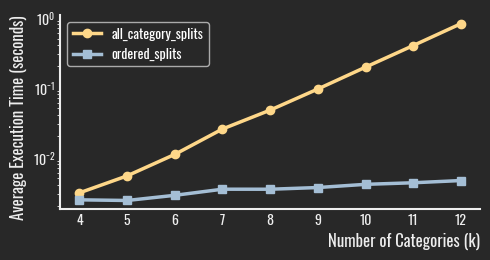

In [13]:
df_results = experiment(range(4, 13), value_type='binary')

plot_times(df_results)
plt.show()

#### Regression Target — Mean Squared Error

In [ ]:
df_results_cont = experiment(range(4, 10), value_type='continuous')
plot_times(df_results_cont)
plt.show()

Number of distinct categories: 4


100%|██████████| 100/100 [00:00<00:00, 137.52it/s]


Number of distinct categories: 5


100%|██████████| 100/100 [00:01<00:00, 79.05it/s]


Number of distinct categories: 6


100%|██████████| 100/100 [00:02<00:00, 42.08it/s]


Number of distinct categories: 7


100%|██████████| 100/100 [00:04<00:00, 21.77it/s]


Number of distinct categories: 8


100%|██████████| 100/100 [00:08<00:00, 11.47it/s]


Number of distinct categories: 9


100%|██████████| 100/100 [00:17<00:00,  5.77it/s]


This is not required for the current experiment but could be valuable for other applications.


In [ ]:
def mean_target_decode(encoded_column, mean_map):
    reverse_map = {v: k for k, v in mean_map.items()}
    decoded_column = encoded_column.map(reverse_map)
    return decoded_column